<a href="https://colab.research.google.com/github/ravellys/PID-1/blob/master/porosidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install porespy

In [2]:
import os
import imageio
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import filters as anything
import pandas as pd
import porespy as ps
from tqdm import tqdm

%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Variancia interclasse
def variance(t, hist, bin_centers):
  
  weight1 = np.sum(hist[:t])
  weight2 = np.sum(hist[t:])

  if weight1 > 0 and  weight2:
    mean1 = np.sum(hist[:t] * bin_centers[:t]) / weight1
    mean2 = np.sum(hist[t:] * bin_centers[t:]) / weight2
  else:
    mean1 = 0 
    mean2 = 0
  var = weight1*weight2*(mean1 - mean2)**2

  return var

# METODO DE OTSU
def OtsuThersh(im, nbins = 256):
  hist, bin_centers = sk.exposure.histogram(im.ravel(), nbins, source_range='image')
  hist = hist.astype(float)
  hist = np.array(hist)/hist.sum()
  var = []
  for i in range(len(bin_centers)):
    var.append(variance(i,hist,bin_centers))
  var = np.array(var)

  pos_thersh = np.argmax(var)
  threshold = bin_centers[pos_thersh-1]
  return threshold

In [15]:
def plot_comp_slice(slice, im, im_bin):
  fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(im[:,:, slice], cmap=plt.cm.gray)
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), range=(im.min(),im.max()), bins=2**8)
  ax[1].set_title('Histogram')
  ax[1].axvline(thresh, color='r')

  ax[2].imshow(im_bin[:, :, slice], cmap=plt.cm.gray)
  ax[2].set_title('Thresholded')
  ax[2].axis('off')

  plt.show()

In [18]:
#plota imagem
def plot_im(im, im_bin, thresh, pos = 4):   
  fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(im[:,:, pos], cmap=plt.cm.gray)  
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), bins=2**8)
  ax[1].set_title('Histogram')
  ax[1].axvline(thresh, color='r')

  ax[2].imshow(im_bin[:, :, pos], cmap=plt.cm.gray)
  ax[2].set_title('Thresholded')
  ax[2].axis('off')

  plt.show()

In [8]:
def im_recort(im,x,y,z):
  x_size,y_size,z_size = im.shape
  s_x,s_y,s_z = np.array([(x_size-x)/2,(y_size-y)/2,(z_size-z)/2]).astype(int)
  e_x,e_y,e_z = np.array([x_size-(x_size-x)/2,y_size-(y_size-y)/2,z_size-(z_size-z)/2]).astype(int)

  return im[s_x:e_x,s_y:e_y,s_z:e_z] # separa uma região de 400x400x400

In [9]:
def import_file(path):
  list_files = os.listdir(path) # lista de arquivos dentro da pasta das amostras
  list_files = np.sort(np.array(list_files)) # organizar os arquivos
  im = [] # inicialização do vetor de armazenamento

  for file in tqdm(list_files) :
    fetch_file = os.path.join(path, file)  
    image = np.array(imageio.imread(fetch_file)) # importa imagem e converte em numpy
 
    im.append(image.T) # Adiciona matriz numpy ao vetor de armazenameto

  im = np.array(im)
  return im[:,:,:].T  

In [10]:
def vec_Thres(im,func):
  vec_thres =  []
  for method in func:
    method_to_call = getattr(sk.filters.thresholding, method)
    vec_thres.append(method_to_call(im))
  return np.array(vec_thres)  

In [11]:
def df_porosityProfile(list_im_bin,functions_str):
  matrix_porosity = []
  for image in list_im_bin:
    vec_porosity = []
    for image_ in image.T:
      vec_porosity.append(image_.sum()/np.prod(image_.shape))  
    vec_porosity = np.array(vec_porosity)
    matrix_porosity.append(vec_porosity)
  matrix_porosity = np.array(matrix_porosity)

  df_porosit = pd.DataFrame(matrix_porosity.T, columns = functions_str)
  df_porosit['stack'] = np.linspace(1,len(df_porosit),len(df_porosit))
  return df_porosit

In [12]:
#funções Globais disponíveis
sk.filters.thresholding.__all__

['try_all_threshold',
 'threshold_otsu',
 'threshold_yen',
 'threshold_isodata',
 'threshold_li',
 'threshold_local',
 'threshold_minimum',
 'threshold_mean',
 'threshold_niblack',
 'threshold_sauvola',
 'threshold_triangle',
 'apply_hysteresis_threshold',
 'threshold_multiotsu']

In [13]:
functions_str = ['threshold_otsu',
                 'threshold_isodata',
                 'threshold_li']

In [14]:
'drive/My Drive/Artigo Segmentação/Imagens/CM17P2S1_50gHu'
path = 'drive/My Drive/Artigo Segmentação/Imagens/CM17P2S1_50gHu' #pasta da amostra
im = import_file(path)
print(im.shape)

100%|██████████| 840/840 [04:20<00:00,  3.22it/s]


(840, 840, 840)


In [ ]:
def porosidade(im,thresh):
  im_bin = im <= thresh
  return np.sum(im_bin)/np.prod((im_bin.shape))

interval = np.linspace(im.min(),im.max(),100)
poros_thres = [porosidade(im,thresh) for thresh in tqdm(interval)]


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Text(0, 0.5, 'porosity')

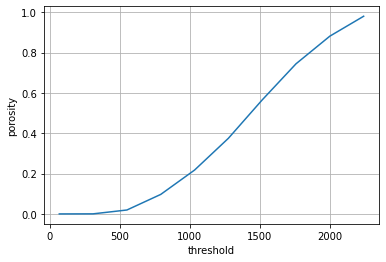

In [ ]:
plt.plot(interval[:10],poros_thres[:10])
plt.grid()
plt.xlabel("threshold")
plt.ylabel("porosity")

In [16]:
list_thres = vec_Thres(im,functions_str)
list_im_bin = [im <= thresh for thresh in list_thres]
list_porosity = [im_bin.sum()/np.prod((im_bin.shape)) for im_bin in list_im_bin]

slice nº 0


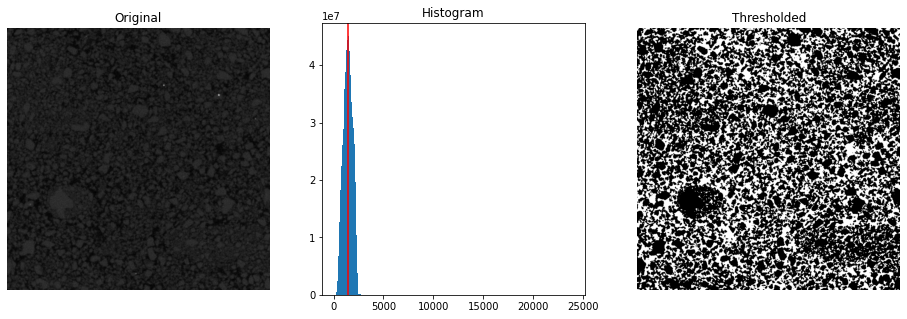

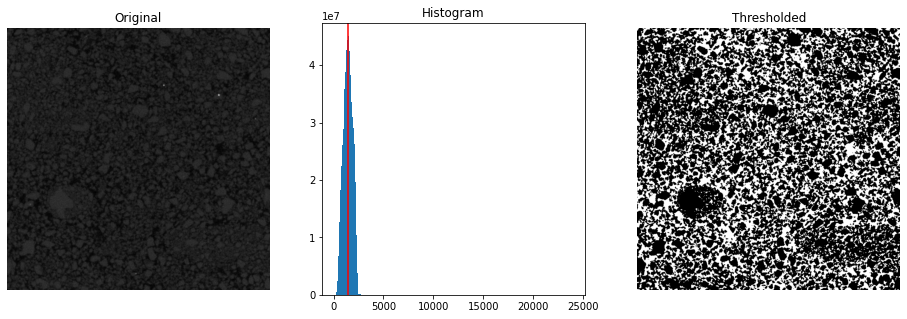

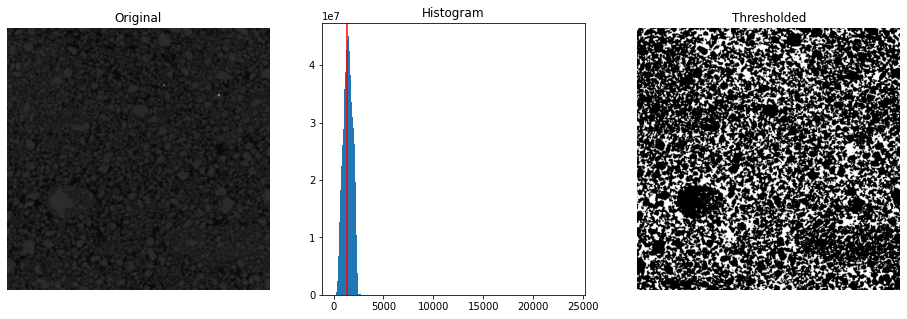

slice nº 419


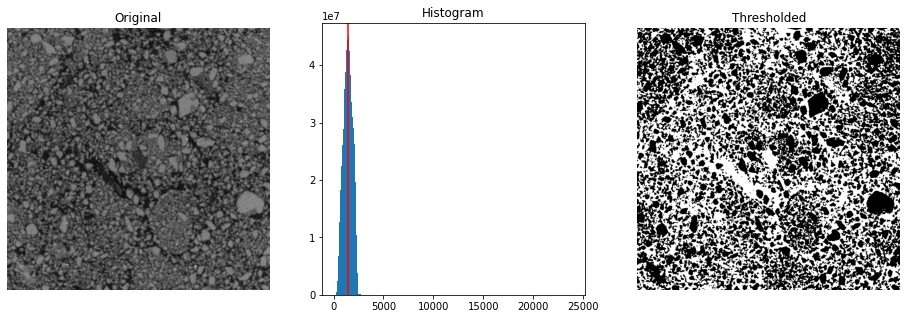

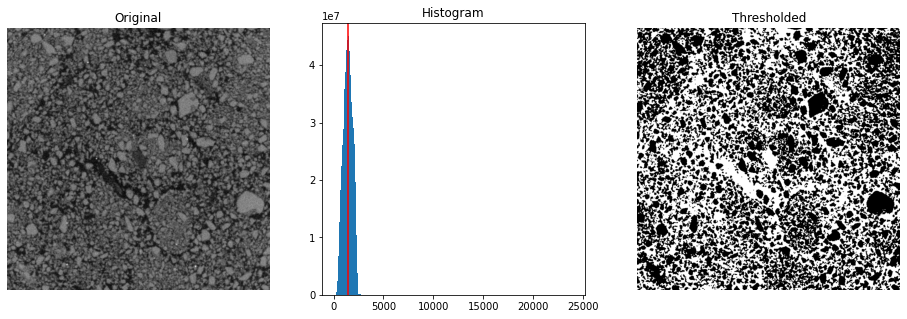

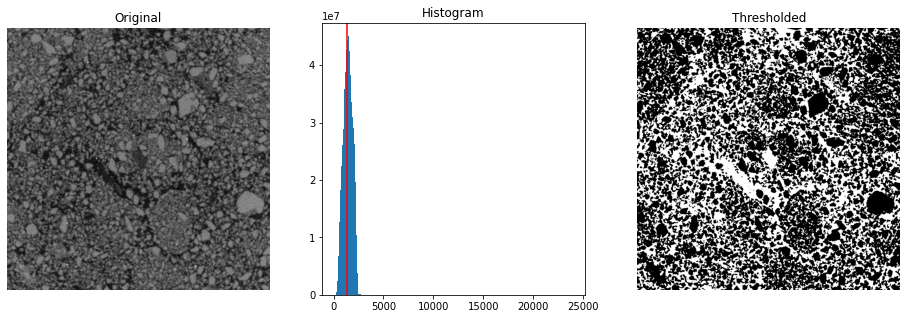

slice nº 839


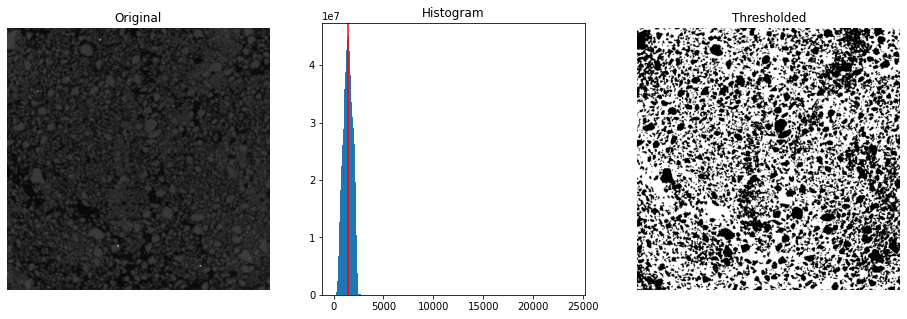

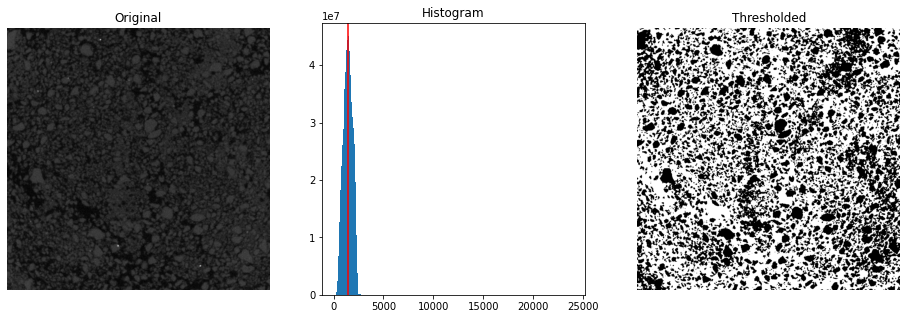

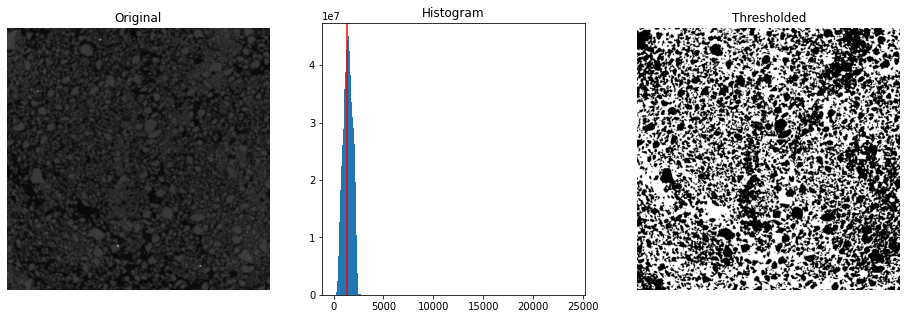

In [19]:
pos = [0,419,839]
for p in pos:
  print(f'slice nº {p}')
  for im_bin, thresh in zip(list_im_bin, list_thres):
    plot_im(im, im_bin, thresh, p) 

In [20]:
df = pd.DataFrame(np.array([list_porosity,list_thres.astype(int)]), columns = functions_str, index = ['porosity','threshold'] )
df.head()

,threshold_otsu,threshold_isodata,threshold_li
porosity,0.478347,0.477374,0.404644
threshold,1410.000000,1409.000000,1316.000000


In [21]:
df_porosit = df_porosityProfile(list_im_bin,functions_str)
df_porosit.head()

,threshold_otsu,threshold_isodata,threshold_li,stack
0,0.368247,0.367354,0.298696,1.0
1,0.365883,0.364926,0.294076,2.0
2,0.367348,0.366341,0.295948,3.0
3,0.369996,0.369016,0.298306,4.0
4,0.371912,0.371015,0.300897,5.0


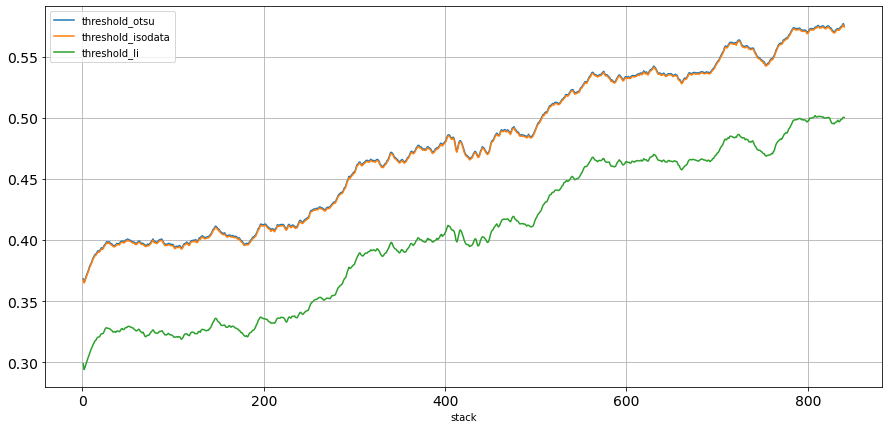

In [22]:
df_porosit.plot( x = 'stack', y = functions_str,
                grid = True, 
                figsize = (15,7), 
                fontsize = 14)

100%|██████████| 1000/1000 [01:36<00:00, 10.32it/s]


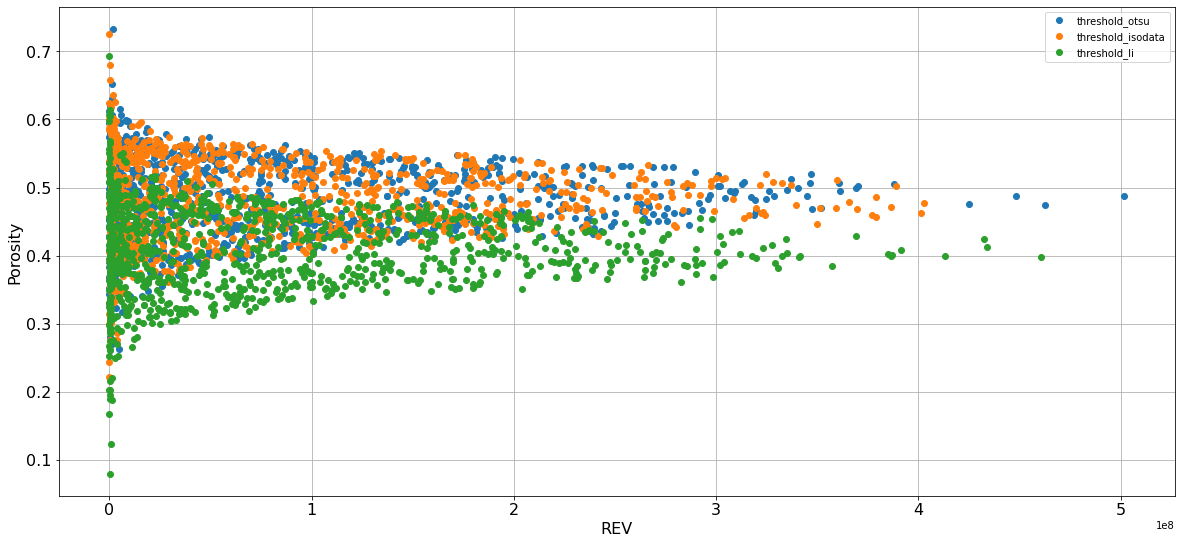

In [23]:
plt.figure(figsize=(20, 9))
for im,label in zip(list_im_bin,functions_str):
  rev = ps.metrics.representative_elementary_volume(im, npoints=1000)
  plt.plot(rev.volume, rev.porosity,'o', label = label, fillstyle = None) 
plt.xticks(fontsize = 16)
plt.xlabel("REV", fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Porosity", fontsize = 16)
plt.legend()
plt.grid(True) 

In [24]:
import scipy.ndimage as spim

def regionprops_3D(im):
    
    results = sk.measure.regionprops(im)
    for i in tqdm(range(len(results))):
        mask = results[i].image
        mask_padded = np.pad(mask, pad_width=1, mode='constant')
        temp = spim.distance_transform_edt(mask_padded)
        dt = ps.tools.extract_subsection(temp, shape=mask.shape)
        # ---------------------------------------------------------------------
        # Slice indices
        results[i].slice = results[i]._slice
        # ---------------------------------------------------------------------
        # Volume of regions in voxels
        results[i].volume = results[i].area
        # ---------------------------------------------------------------------
        # Volume of bounding box, in voxels
        results[i].bbox_volume = np.prod(mask.shape)
        # ---------------------------------------------------------------------
        # Create an image of the border
        results[i].border = dt == 1
        # ---------------------------------------------------------------------
        # Create an image of the maximal inscribed sphere
        r = dt.max()
        inv_dt = spim.distance_transform_edt(dt < r)
        results[i].inscribed_sphere = inv_dt < r
        # ---------------------------------------------------------------------
        # Find surface area using marching cubes and analyze the mesh
        tmp = np.pad(np.atleast_3d(mask), pad_width=1, mode='constant')
        tmp = spim.convolve(tmp, weights=sk.morphology.ball(1))/5
        verts, faces, norms, vals = sk.measure.marching_cubes_lewiner(volume=tmp, level=0)
        results[i].surface_mesh_vertices = verts
        results[i].surface_mesh_simplices = faces
        area = sk.measure.mesh_surface_area(verts, faces)
        results[i].surface_area = area
        # ---------------------------------------------------------------------
        # Find sphericity
        vol = results[i].volume
        r = (3/4/np.pi*vol)**(1/3)
        a_equiv = 4*np.pi*(r)**2
        a_region = results[i].surface_area
        results[i].sphericity = a_equiv/a_region
        # ---------------------------------------------------------------------
        # Find skeleton of region
        results[i].skeleton = sk.morphology.skeletonize_3d(mask)
        # ---------------------------------------------------------------------
        # Volume of convex image, equal to area in 2D, so just translating
        results[i].convex_volume = results[i].convex_area

    return results

In [25]:
def list_porosimetry(list_im_bin,x,y,z):
  data = []
  for image in tqdm(list_im_bin):
    image = image.astype(int)
    im_rec = im_recort(image,x,y,z)
    mip = ps.filters.porosimetry(im_rec)
    data.append(ps.metrics.pore_size_distribution(mip, log=False,voxel_size = 50*10**-6))
  return data

In [26]:
list_data = list_porosimetry(list_im_bin,300,300,300)  

100%|██████████| 3/3 [04:23<00:00, 87.76s/it]


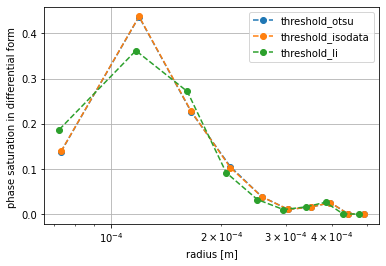

In [27]:
for data, label in zip(list_data, functions_str):
  plt.plot(data.R, data.satn, 'o--', label = label)
plt.xscale('log')
plt.xlabel('radius [m]')
plt.ylabel('phase saturation in differential form ')
plt.legend()
plt.grid()

In [28]:
def Se_VGM(h, alfa, n):
  return 1/(1+(alfa*h)**n)**(1-1/n)

In [29]:
from scipy.optimize import curve_fit

def ajust_retentionCurve(data):
  R = data.R
  h = (.15/(R*100))
  Se = np.cumsum(data.satn)
  param = curve_fit(Se_VGM,h,Se, p0 = [.01,1.2])
  return param[0]

[0.08373045 4.13294966]
[0.08356657 4.14016856]
[0.08186431 3.96855687]


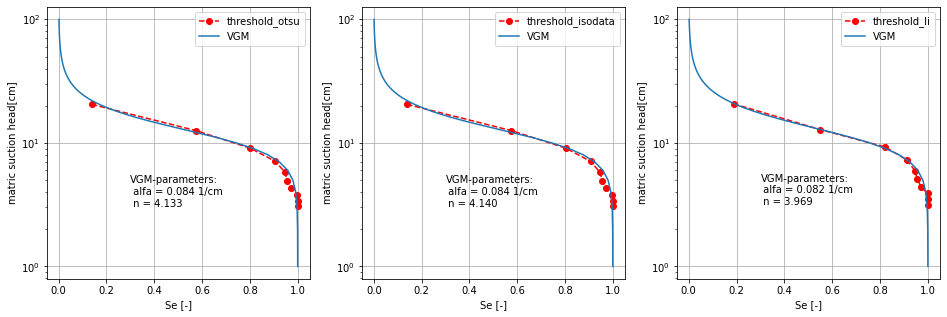

In [30]:
fig, axes = plt.subplots(ncols=len(functions_str), figsize=(16, 5))

for data, label,ax in zip(list_data, functions_str,axes.ravel()):
  R = data.R
  h = (.15/(R*100))
  
  param_VGM = ajust_retentionCurve(data)
  print(param_VGM)

  h_ = np.linspace(1,100,100)
  Se = Se_VGM(h_, *param_VGM)
  
  ax.plot( np.cumsum(data.satn), h, 'ro--', label = label)
  ax.text(.3,h[-1],'VGM-parameters:\n alfa = %.3f 1/cm \n n = %.3f' %(param_VGM[0],param_VGM[1]))
  ax.set_yscale('log')
  ax.plot( Se, h_, label = 'VGM' )
  ax.set_ylabel('matric suction head[cm]')
  ax.set_xlabel('Se [-]')
  ax.legend()
  ax.grid()
plt.show()


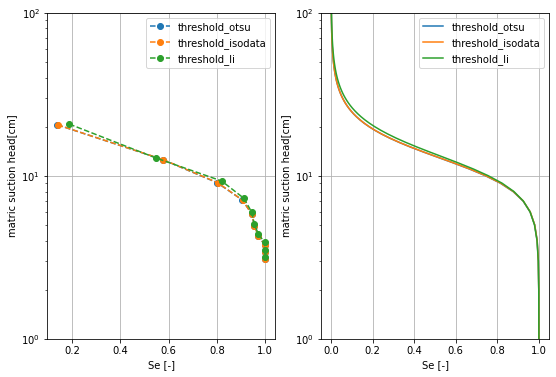

In [31]:
fig, ax = plt.subplots(ncols = 2, figsize=(9, 6))

for data, label in zip(list_data, functions_str):
  R = data.R
  h = (.15/(R*100))
  
  param_VGM = ajust_retentionCurve(data)
  h_ = np.linspace(1,100,100)
  Se = Se_VGM(h_, *param_VGM)
  
  ax[1].plot( Se, h_, label =  label )
  ax[0].plot( np.cumsum(data.satn), h, 'o--', label = label)

for i in ax:
  i.set_ylim(1,100)
  i.set_yscale('log')
  i.set_ylabel('matric suction head[cm]')
  i.set_xlabel('Se [-]')
  i.legend()
  i.grid()

plt.show()